In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

In [2]:
import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp

In [3]:
gcn_file = "../GCN Files/sims_2024/nk_taylor_rule.gcn"
mod = ge.model_from_gcn(gcn_file)

Model Building Complete.
Found:
	17 equations
	17 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	13 parameters
		 12 / 13 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
pi_bar_values = np.linspace(-0.005, 0.01, 100)
ss_pi_bar = pd.DataFrame(
    [mod.steady_state(pi_bar=1 + pi_bar, sigma=1.0) for pi_bar in pi_bar_values],
    index=pi_bar_values,
)

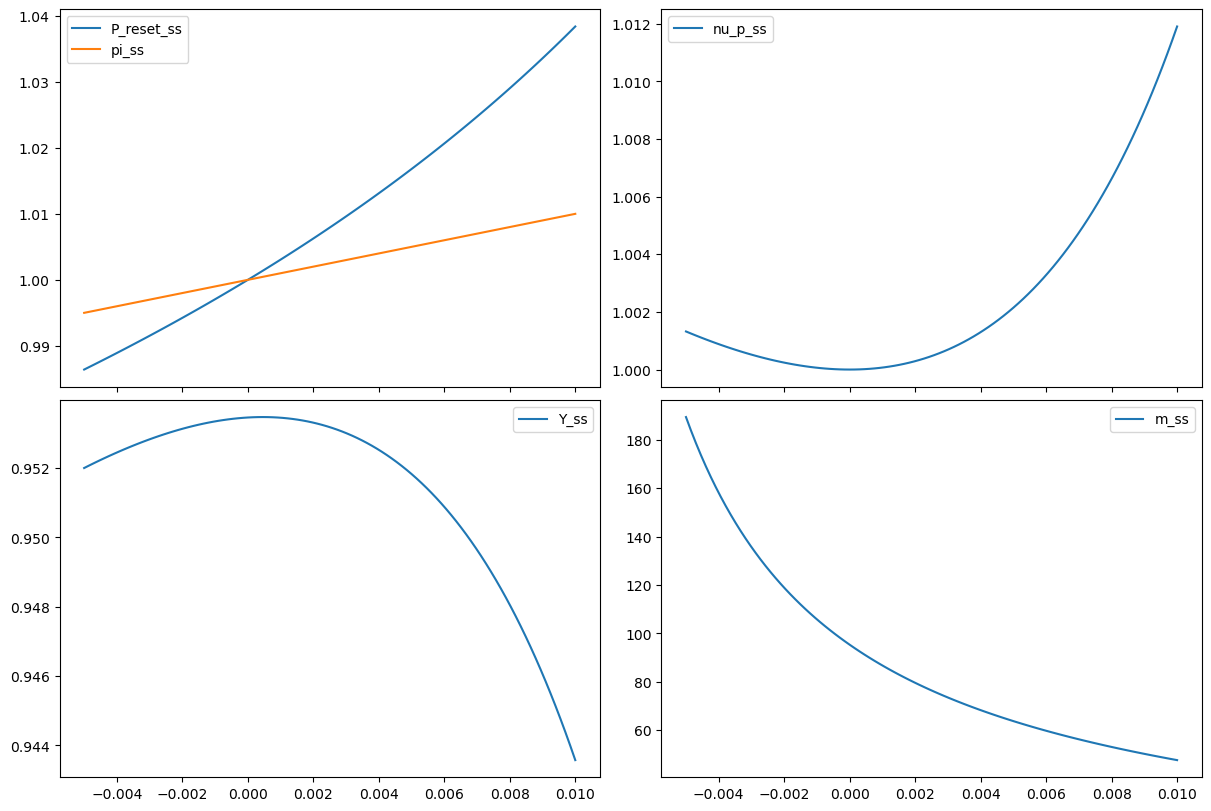

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, layout="constrained")
variables = [["P_reset_ss", "pi_ss"], ["nu_p_ss"], ["Y_ss"], ["m_ss"]]
for var, axis in zip(variables, fig.axes):
    ss_pi_bar[var].plot(ax=axis)
plt.show()

In [6]:
irf_params = {
    "beta": 0.99,
    "sigma": 3.0,
    "chi": 1,
    "theta": 1,
    "phi": 3 / 4,
    "epsilon": 11,
    "psi": 1,
    "pi_bar": 1.0,
    "rho_A": 0.9,
    "rho_i": 0.5,
    "phi_pi": 1.5,
    "phi_Y": 0.5,
}

irf = ge.impulse_response_function(
    mod,
    **irf_params,
    shock_size={"epsilon_A": 0.01, "epsilon_i": 0.01},
    simulation_length=20,
    not_loglin_variables=["i", "pi"],
)

The following variables will not be log-linearized at the user's request: ['i', 'pi']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


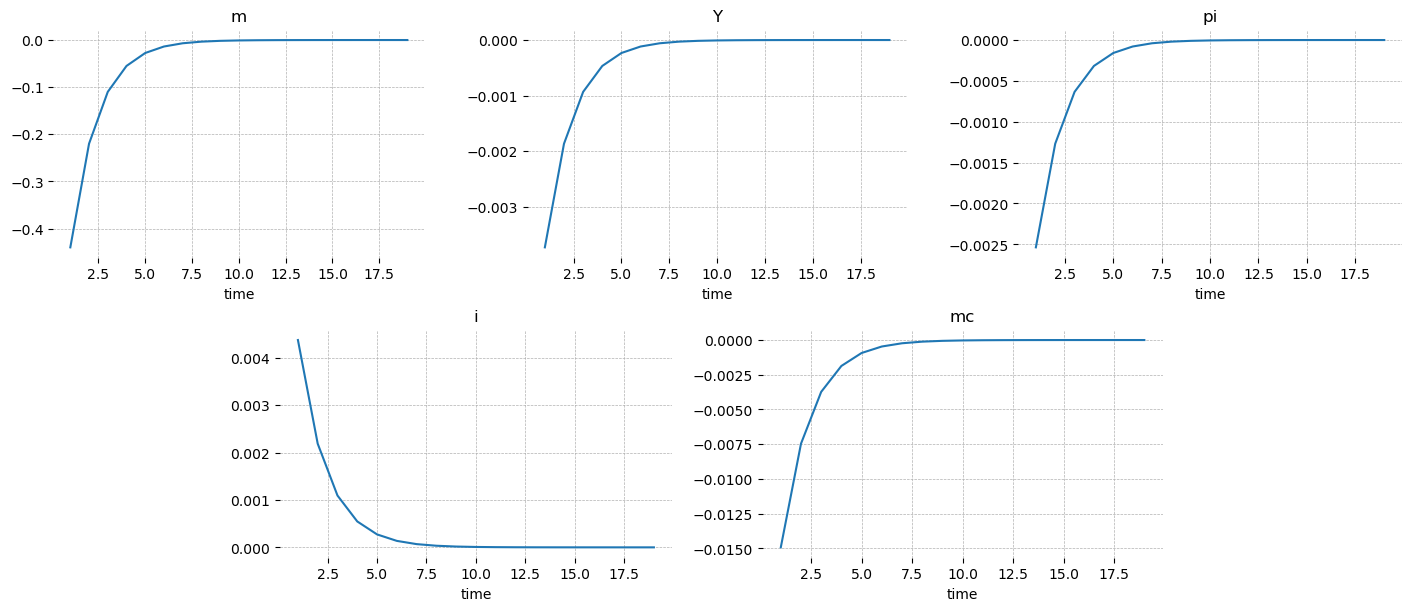

In [7]:
import gEconpy.plotting as gp

gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["m", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_i"],
    n_cols=3,
    figsize=(14, 6),
);

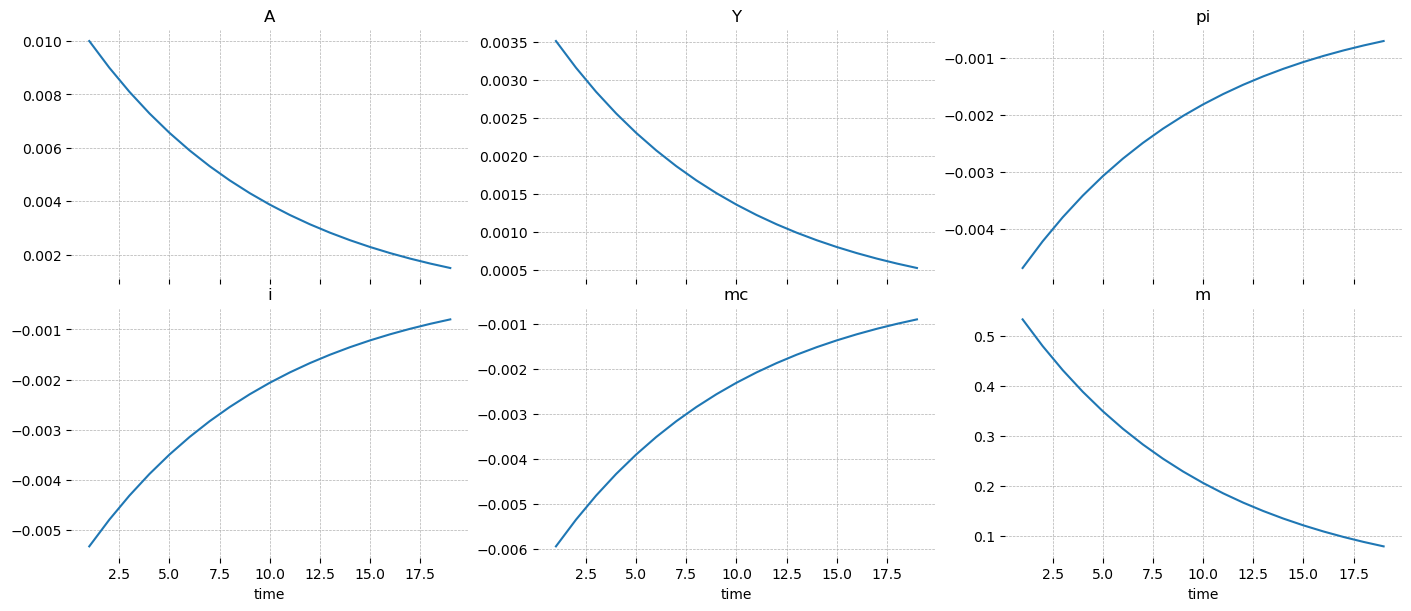

In [8]:
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["A", "Y", "pi", "i", "mc", "m"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

In [9]:
irf_by_phi = {
    f"phi = {phi}": ge.impulse_response_function(
        mod,
        **(irf_params | {"phi": phi, "pi_bar": 1.001}),
        shock_size={"epsilon_A": 0.01, "epsilon_i": 0.01},
        simulation_length=20,
        not_loglin_variables=["i", "pi"],
        verbose=False,
    ).isel(time=slice(1, None))
    for phi in [0, 0.75, 0.9]
}

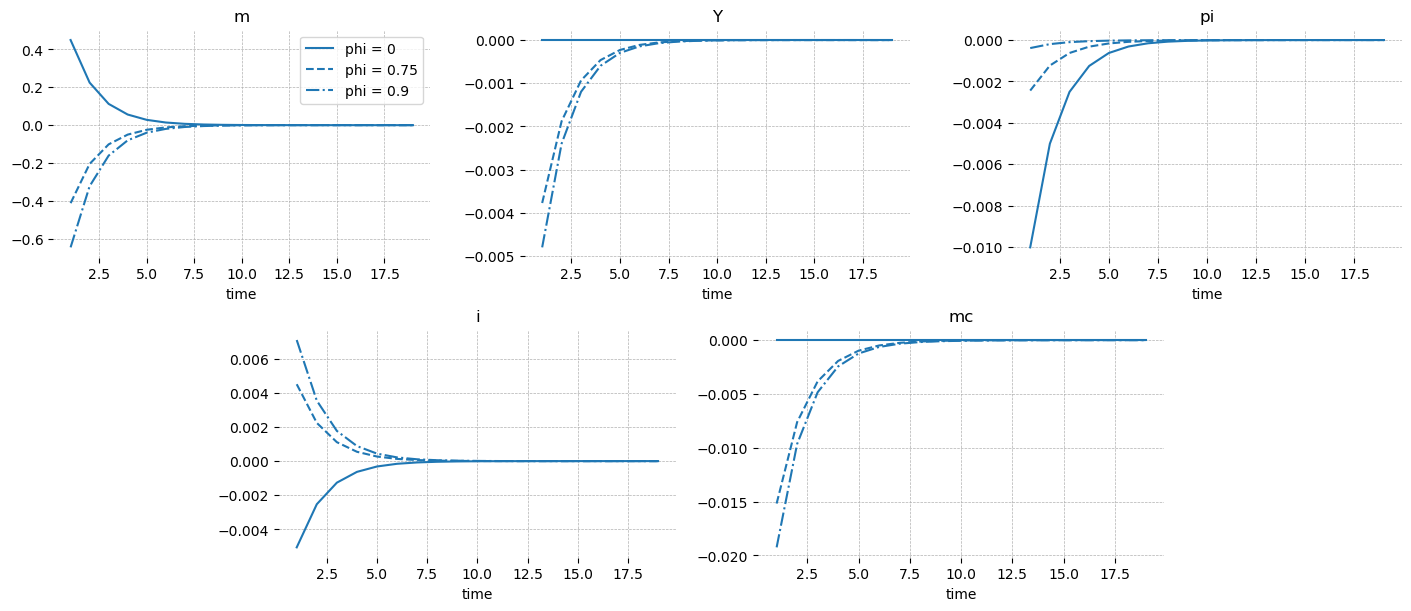

In [10]:
gp.plot_irf(
    irf_by_phi,
    vars_to_plot=["m", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_i"],
    n_cols=3,
    figsize=(14, 6),
);

The following variables will not be log-linearized at the user's request: ['i', 'pi']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


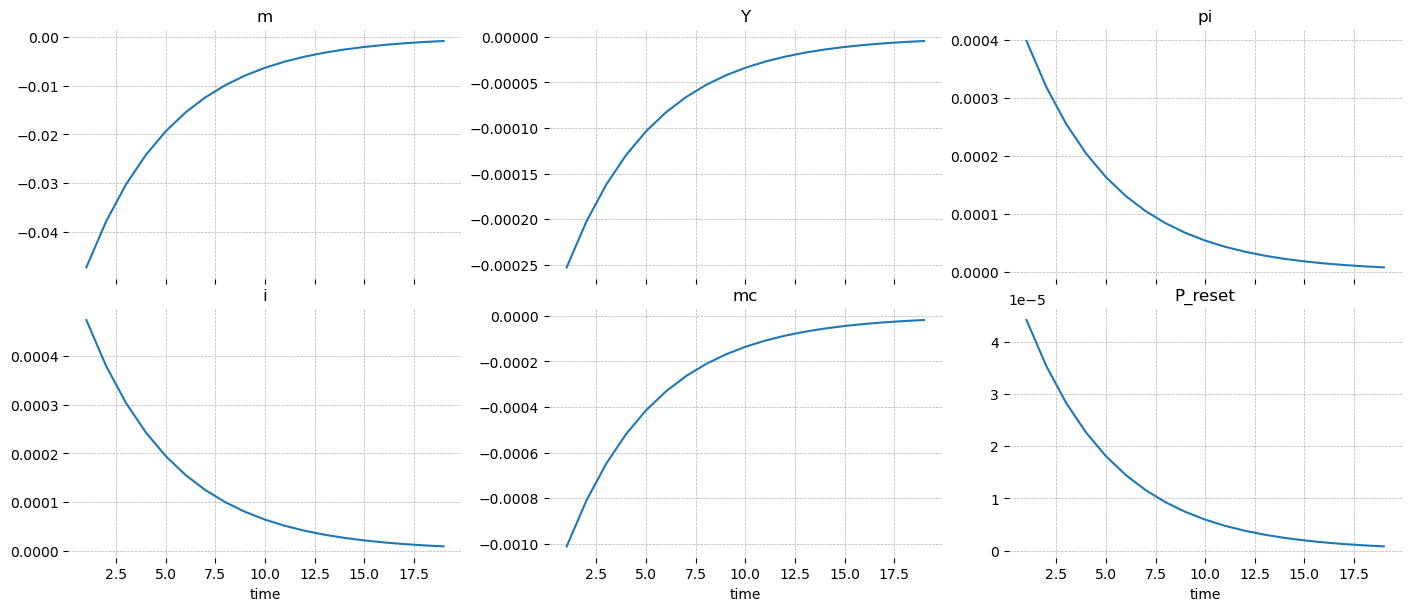

In [11]:
irf = ge.impulse_response_function(
    mod,
    phi=0.1,
    shock_size={"epsilon_markup": 0.01},
    simulation_length=20,
    not_loglin_variables=["i", "pi"],
)
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["m", "Y", "pi", "i", "mc", "P_reset"],
    shocks_to_plot=["epsilon_markup"],
    n_cols=3,
    figsize=(14, 6),
);

In [12]:
T, R = mod.solve_model(log_linearize=True, not_loglin_variables=["i", "pi"])

The following variables will not be log-linearized at the user's request: ['i', 'pi']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [13]:
ge.matrix_to_dataframe(T, mod).round(3)

A    C    N  P_reset  SDF  X_hat_1  X_hat_2    Y  \
A                0.900  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
C                0.316  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
N               -0.584  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
P_reset         -1.265  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
SDF             -0.948  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
X_hat_1         -9.298 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
X_hat_2         -8.034 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
Y                0.316  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
epsilon_tv       0.000  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
i               -0.479 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
interest_shock   0.000 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
lambda          -0.948  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
m               47.899  0.0  0.0      0.0  0.0      0.0      0.0  0.0   
mc              -0.535 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
nu_p            -0.000 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
pi              -0.422 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   
w                0.365 -0.0 -0.0     -0.0 -0.0     -0.0     -0.0 -0.0   

                epsilon_tv    i  interest_shock  lambda    m   mc    nu_p  \
A                   -0.000  0.0           0.000     0.0  0.0  0.0   0.000   
C                    0.016  0.0          -0.187     0.0  0.0  0.0  -0.083   
N                    0.016  0.0          -0.187     0.0  0.0  0.0   0.667   
P_reset             -0.076  0.0          -0.381     0.0  0.0  0.0   0.417   
SDF                 -0.048  0.0           0.560    -1.0  0.0  0.0   0.250   
X_hat_1             -0.340 -0.0          -1.536    -0.0 -0.0 -0.0   2.009   
X_hat_2             -0.343 -0.0          -1.156    -0.0 -0.0 -0.0   1.592   
Y                    0.016  0.0          -0.187     0.0  0.0  0.0  -0.083   
epsilon_tv           0.800  0.0           0.000     0.0  0.0  0.0   0.000   
i                   -0.030 -0.0           0.219    -0.0 -0.0 -0.0   0.168   
interest_shock       0.000 -0.0           0.500    -0.0 -0.0 -0.0  -0.000   
lambda              -0.048  0.0           0.560     0.0  0.0  0.0   0.250   
m                    3.019  0.0         -21.987     0.0  0.0  0.0 -16.750   
mc                   0.065 -0.0          -0.746    -0.0 -0.0 -0.0   0.417   
nu_p                -0.000 -0.0          -0.000    -0.0 -0.0 -0.0   0.750   
pi                  -0.025 -0.0          -0.127    -0.0 -0.0 -0.0   0.139   
w                    0.065 -0.0          -0.746    -0.0 -0.0 -0.0   0.417   

                 pi    w  
A               0.0  0.0  
C               0.0  0.0  
N               0.0  0.0  
P_reset         0.0  0.0  
SDF             0.0  0.0  
X_hat_1        -0.0 -0.0  
X_hat_2        -0.0 -0.0  
Y               0.0  0.0  
epsilon_tv      0.0  0.0  
i              -0.0 -0.0  
interest_shock -0.0 -0.0  
lambda          0.0  0.0  
m               0.0  0.0  
mc             -0.0 -0.0  
nu_p           -0.0 -0.0  
pi             -0.0 -0.0  
w              -0.0 -0.0

In [14]:
ge.matrix_to_dataframe(R, mod).round(3)

epsilon_A  epsilon_i  epsilon_markup
A                   1.000      0.000           0.000
C                   0.351     -0.373          -0.020
N                  -0.649     -0.373          -0.020
P_reset            -1.405     -0.761           0.095
SDF                -1.054      1.119           0.061
X_hat_1           -10.332     -3.073           0.424
X_hat_2            -8.926     -2.312           0.429
Y                   0.351     -0.373          -0.020
epsilon_tv          0.000      0.000          -1.000
i                  -0.532      0.437           0.038
interest_shock     -0.000      1.000           0.000
lambda             -1.054      1.119           0.061
m                  53.221    -43.975          -3.773
mc                 -0.595     -1.493          -0.081
nu_p               -0.000     -0.000           0.000
pi                 -0.468     -0.254           0.032
w                   0.405     -1.493          -0.081

In [15]:
ss_mod = ge.statespace_from_gcn(gcn_file, not_loglin_variables=["i", "pi"])

Model Building Complete.
Found:
	17 equations
	17 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	13 parameters
		 12 / 13 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


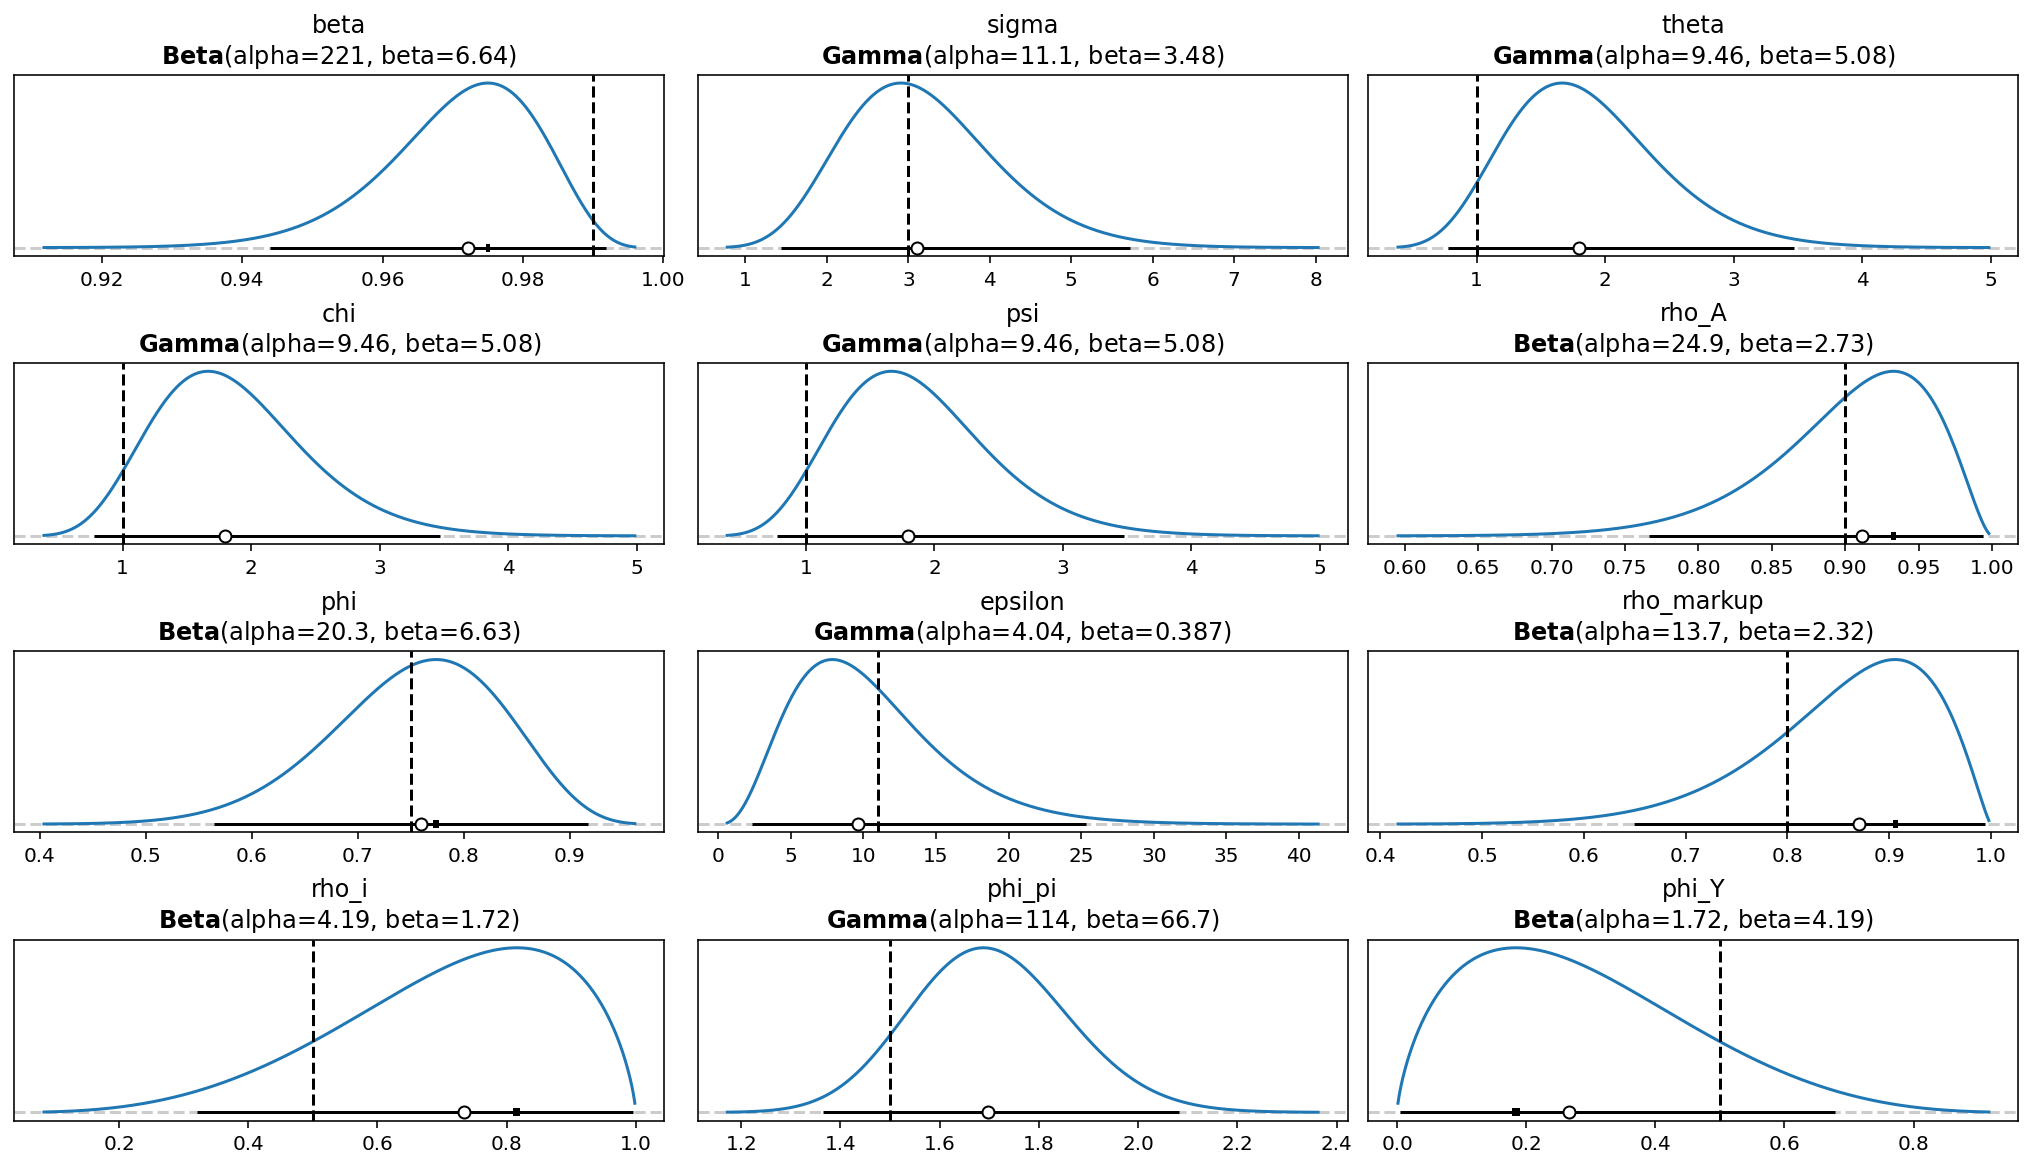

In [16]:
gp.plot_priors(ss_mod, n_cols=3);

In [17]:
ss_mod.configure(
    observed_states=["Y", "C", "N", "pi", "i", "m", "w"],
    measurement_error=["Y", "C", "N", "m", "w"],
    constant_params=["pi_bar"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	epsilon -- shape: (), constraints: None, dims: None
	phi -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	psi -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dims: None
	rho_markup -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	theta -- shape: (), constraints: None, dims: None
	state_cov -- shape: (3, 3), constraints: Positive Semi-Definite, dims: ('shock', 'shock_aux')
	error_sigma_Y -- shape: (), constraints: None, dims: None
	error_sigma_C -- shape: (), constraints: None, dims: None
	error_sigma_N -- shape: (), constraints: None, dims: None
	error_sigma_m -- shape: (), con

In [34]:
import pymc as pm
import preliz as pz

dates = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
dummy_data = pd.DataFrame(np.nan, index=dates, columns=ss_mod.observed_states)

all_priors = ss_mod.param_priors | ss_mod.shock_priors
sd_dist = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False).to_pymc()

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov("state_chol", n=3, eta=6, sd_dist=sd_dist)
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

    ss_mod.build_statespace_graph(
        dummy_data,
        add_bk_check=False,
        add_solver_success_check=True,
        add_norm_check=True,
        add_steady_state_penalty=True,
    )

    prior = pm.sample_prior_predictive()

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_88273/1634901814.py:29: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [beta, chi, epsilon, error_sigma_C, error_sigma_N, error_sigma_Y, error_sigma_m, error_sigma_w, obs, phi, phi_Y, phi_pi, psi, rho_A, rho_i, rho_markup, sigma, state_chol, theta]


In [35]:
prior_trajectories = ss_mod.sample_unconditional_prior(prior)

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x6BFA4F5A0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


Output()

In [36]:
idx = np.random.choice(prior.prior.coords["draw"].values)

true_params = prior.prior.isel(chain=0, draw=idx)
data = prior_trajectories.isel(chain=0, draw=idx).prior_observed
data = (
    data.to_dataframe()
    .drop(columns=["chain", "draw"])
    .unstack("observed_state")
    .droplevel(axis=1, level=0)
)

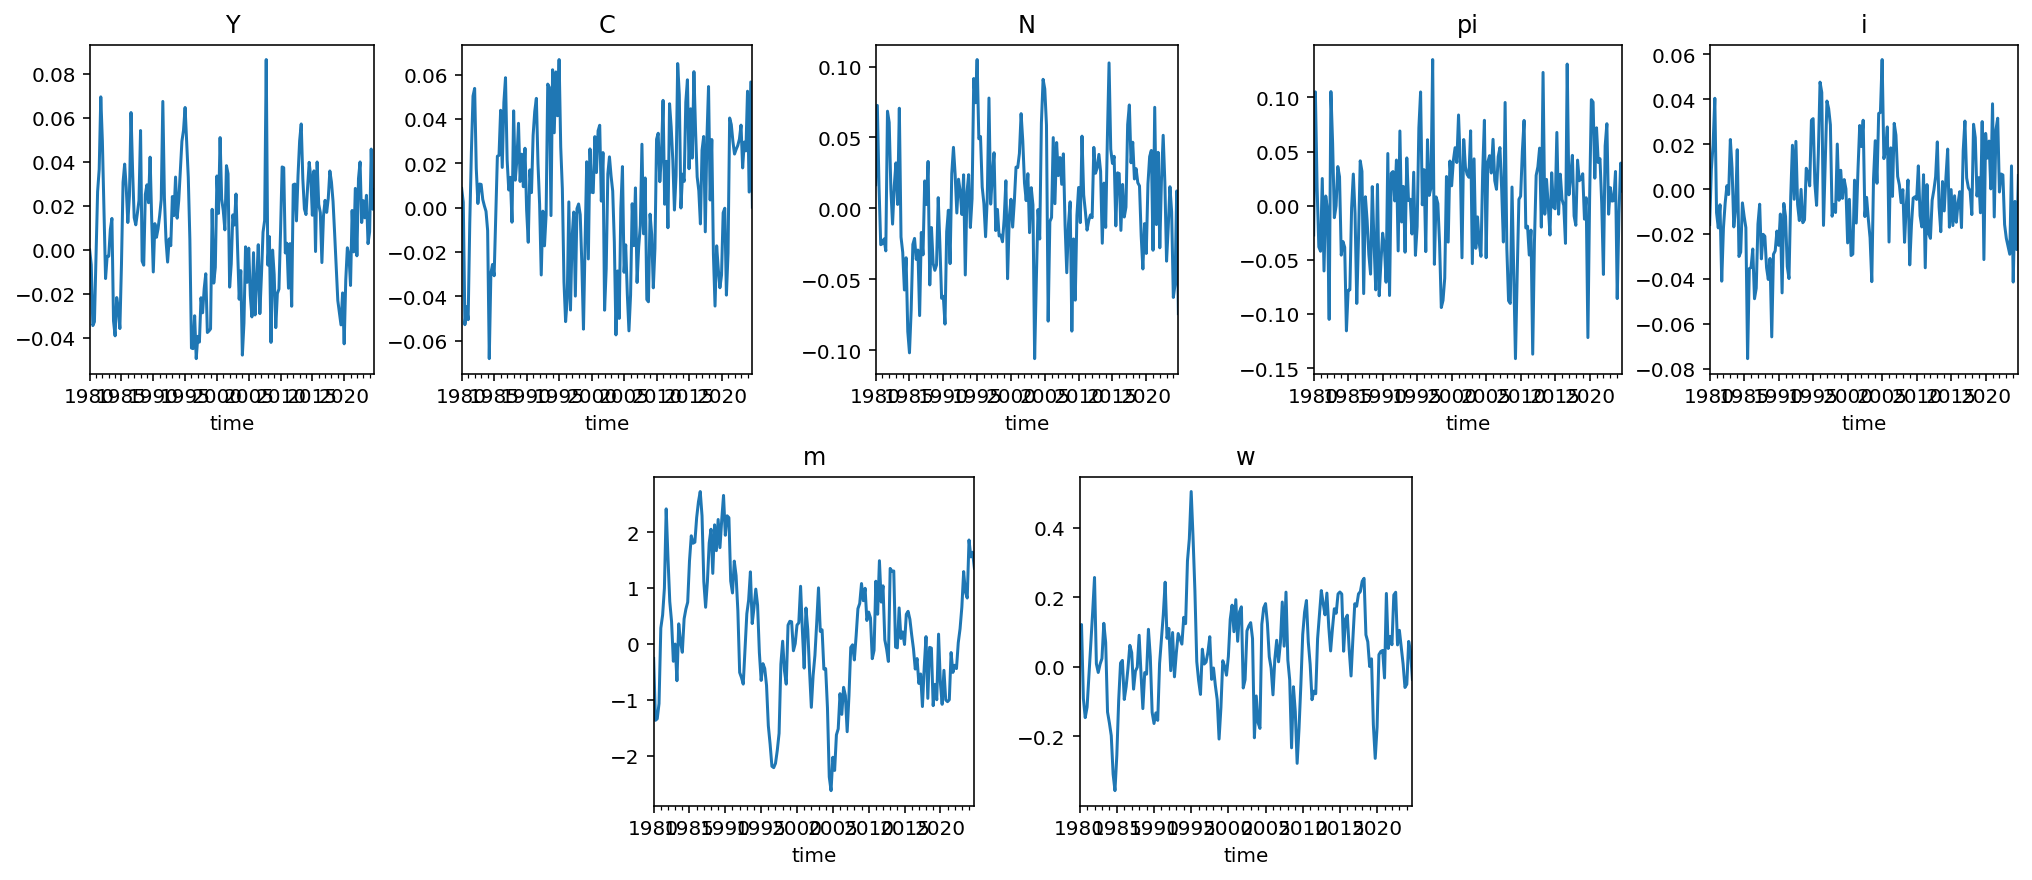

In [37]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)

In [38]:
with pm_mod:
    pm.set_data({"data": data})
    ss_mod._fit_data = data

In [39]:
from pymc.model.transform.optimization import freeze_dims_and_data
import nutpie as ntp

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    initial_points=None,
)

In [44]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=5e-3,
        #                                                 num_layers=5,
        #                                                 nn_width=32,
        batch_size=512,
        initial_skip=512,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=2000,
    draws=500,
    chains=6,
    transform_adapt=True,
)

Chain 4: Total available points: 11
loss from diag: 4.675178663028607
Chain 1: Total available points: 11
loss from diag: 6.064136987394611
Chain 5: Total available points: 11
loss from diag: 3.390637037816653
Chain 0: Total available points: 11
loss from diag: 4.923316483677238
Chain 5: Total available points: 21
loss from diag: 0.9865502752722363
Chain 2: Total available points: 11
loss from diag: 6.046818881705539
Chain 4: Total available points: 21
loss from diag: -0.4422375995573658
Chain 3: Total available points: 11
loss from diag: 6.341754074068675
Chain 0: Total available points: 21
loss from diag: -0.7391707247778787
Chain 4: Total available points: 31
loss from diag: 2.857698319712442
Chain 5: Total available points: 31
loss from diag: 1.497518434678679
Chain 1: Total available points: 21
loss from diag: 1.7543478408866113
Chain 4: Total available points: 41
loss from diag: 2.8274485558302542
Chain 5: Total available points: 41
loss from diag: 3.601772992686938
Chain 2: Tota

2.4439105744840006 [0.73442199 1.1760832  0.47798244 0.81495438 0.32953237 1.0056789
 0.99273737 0.91673021 0.63739193 1.04788251 0.92932058 1.02795634
 0.23192019 0.19824285 0.29315332 0.25864932 0.40863529 0.38996174
 0.77702955 0.72060685 0.51874909 1.13478703 2.44391057]
dct: False
Chain 1: New loss 1.05762724818526, old loss 1.5703111248559338
Chain 5: New loss 0.3270063321258731, old loss 2.022454428334155
Chain 3: New loss 0.26087229880672386, old loss 2.8602743425881165
Chain 0: Total available points: 601
Extending flow...
2.7283144624392124 [0.740294   0.61034538 0.34382429 0.82907757 0.38805323 0.87696792
 1.44611883 0.52451751 2.72831446 0.81836363 1.44017749 0.93459186
 0.29007407 0.20218461 0.34723237 0.49803484 0.25401172 0.3917303
 0.50986572 0.61361203 0.96045159 0.72862667 0.76604343]
dct: False
Chain 2: Total available points: 551
loss before optimization:  4.511071474150729
Chain 0: New loss 1.405761013702326, old loss 2.847378051355537
Chain 1: Total available poin

Chain 5: Total available points: 1151
Chain 3: New loss -0.23023830720462773, old loss 0.08587872649025768
Chain 2: Total available points: 1001
Chain 0: New loss -0.03452081907049358, old loss 0.5218883963439495
Chain 4: New loss 0.33695565936993993, old loss 0.5625026323719182
Chain 3: Total available points: 1051
Chain 2: New loss 0.40250396597720195, old loss 0.7866215416266585
Chain 1: New loss -0.2539438748597275, old loss 0.11124254824387964
Chain 0: Total available points: 1001
Chain 4: Total available points: 1151
Chain 5: New loss -0.3973443869575012, old loss 0.23102680955398072
Chain 1: Total available points: 1201
Chain 2: Total available points: 1051
Chain 0: New loss 0.005745709015335169, old loss 0.3166244286486239
Chain 3: New loss -0.28993464434405797, old loss 0.1415674847374008
Chain 4: New loss 0.3537016035630419, old loss 0.9940140802373626
Chain 1: New loss -0.2349756006229705, old loss 0.042408400442097684
Chain 2: New loss 0.2973409459210981, old loss 0.6331052

Chain 0: New loss -0.5666848270660321, old loss -0.18854504174269848
Chain 2: Total available points: 1651
Chain 3: New loss -0.40949489333699085, old loss -0.03091305042018633
Chain 5: New loss -0.4500006430128643, old loss 0.05293070746530125
Chain 2: New loss -0.3743141135639573, old loss -0.05512174039568911
Chain 0: Total available points: 1651
Chain 3: Total available points: 1701
Chain 0: New loss -0.5462222001164457, old loss -0.29362550439090823
Chain 2: Total available points: 1701
Chain 3: New loss -0.54156683784752, old loss -0.07055597605817912
Chain 2: New loss -0.4208934403737941, old loss -0.28446273910394154
Chain 0: Total available points: 1701
Chain 3: Total available points: 1751
Chain 0: New loss -0.5563356685814568, old loss -0.11734647605580872
Chain 2: Total available points: 1751
Chain 3: New loss -0.5104898758113963, old loss -0.31019107407628754
Chain 2: New loss -0.3976714963260752, old loss -0.09645734925117695
Chain 0: Total available points: 1751
Chain 0:

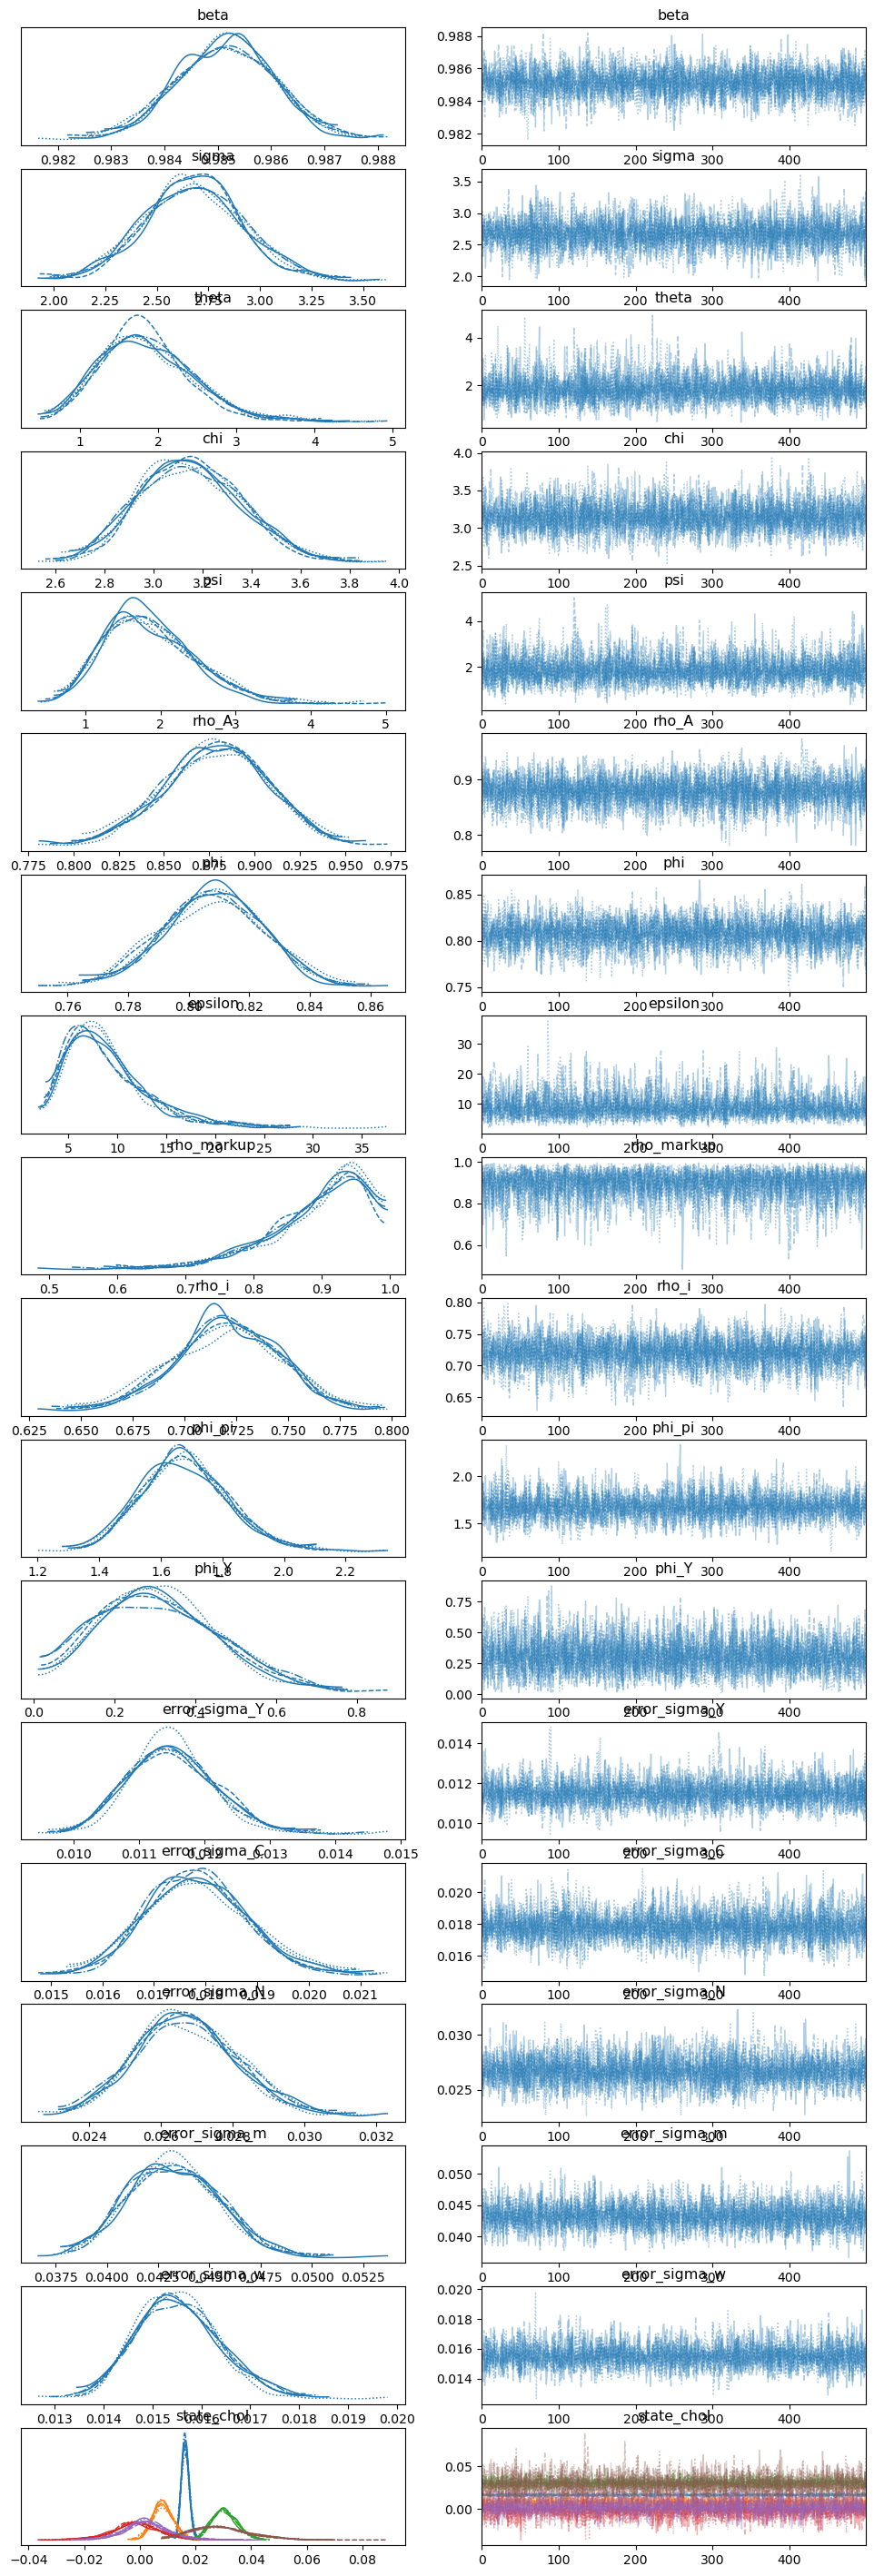

In [45]:
import arviz as az

var_names = [rv.name for rv in pm_mod.free_RVs]
az.plot_trace(idata, var_names=var_names);

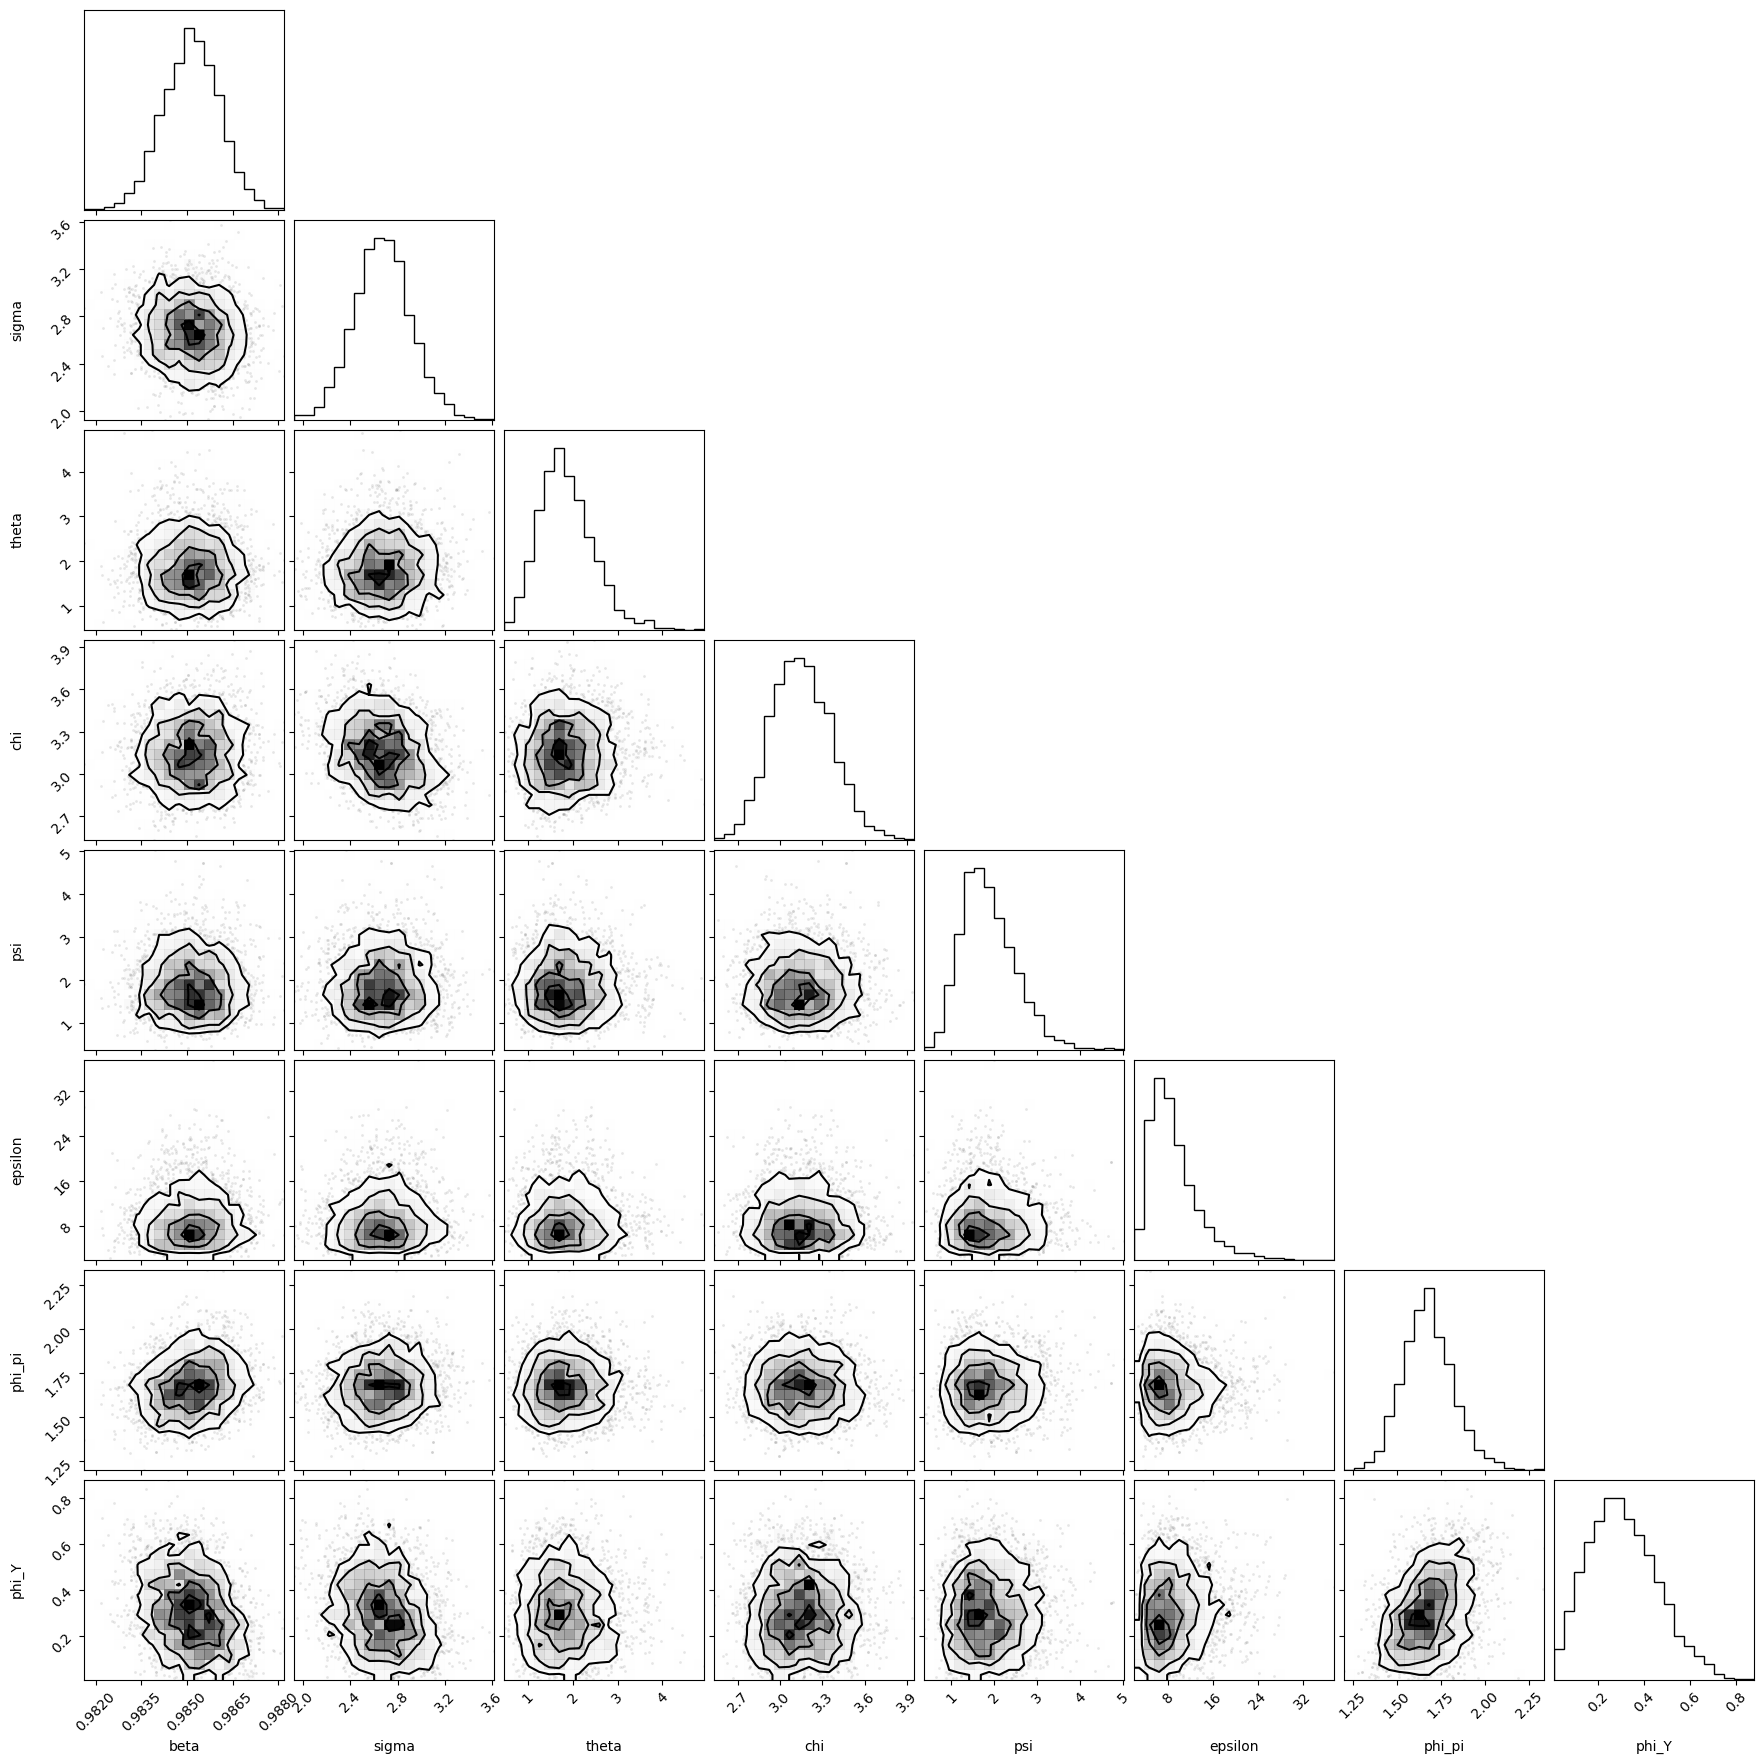

In [52]:
from corner import corner

corner(
    idata,
    var_names=["beta", "sigma", "theta", "chi", "psi", "epsilon", "phi_pi", "phi_Y"],
    marginals=True,
);

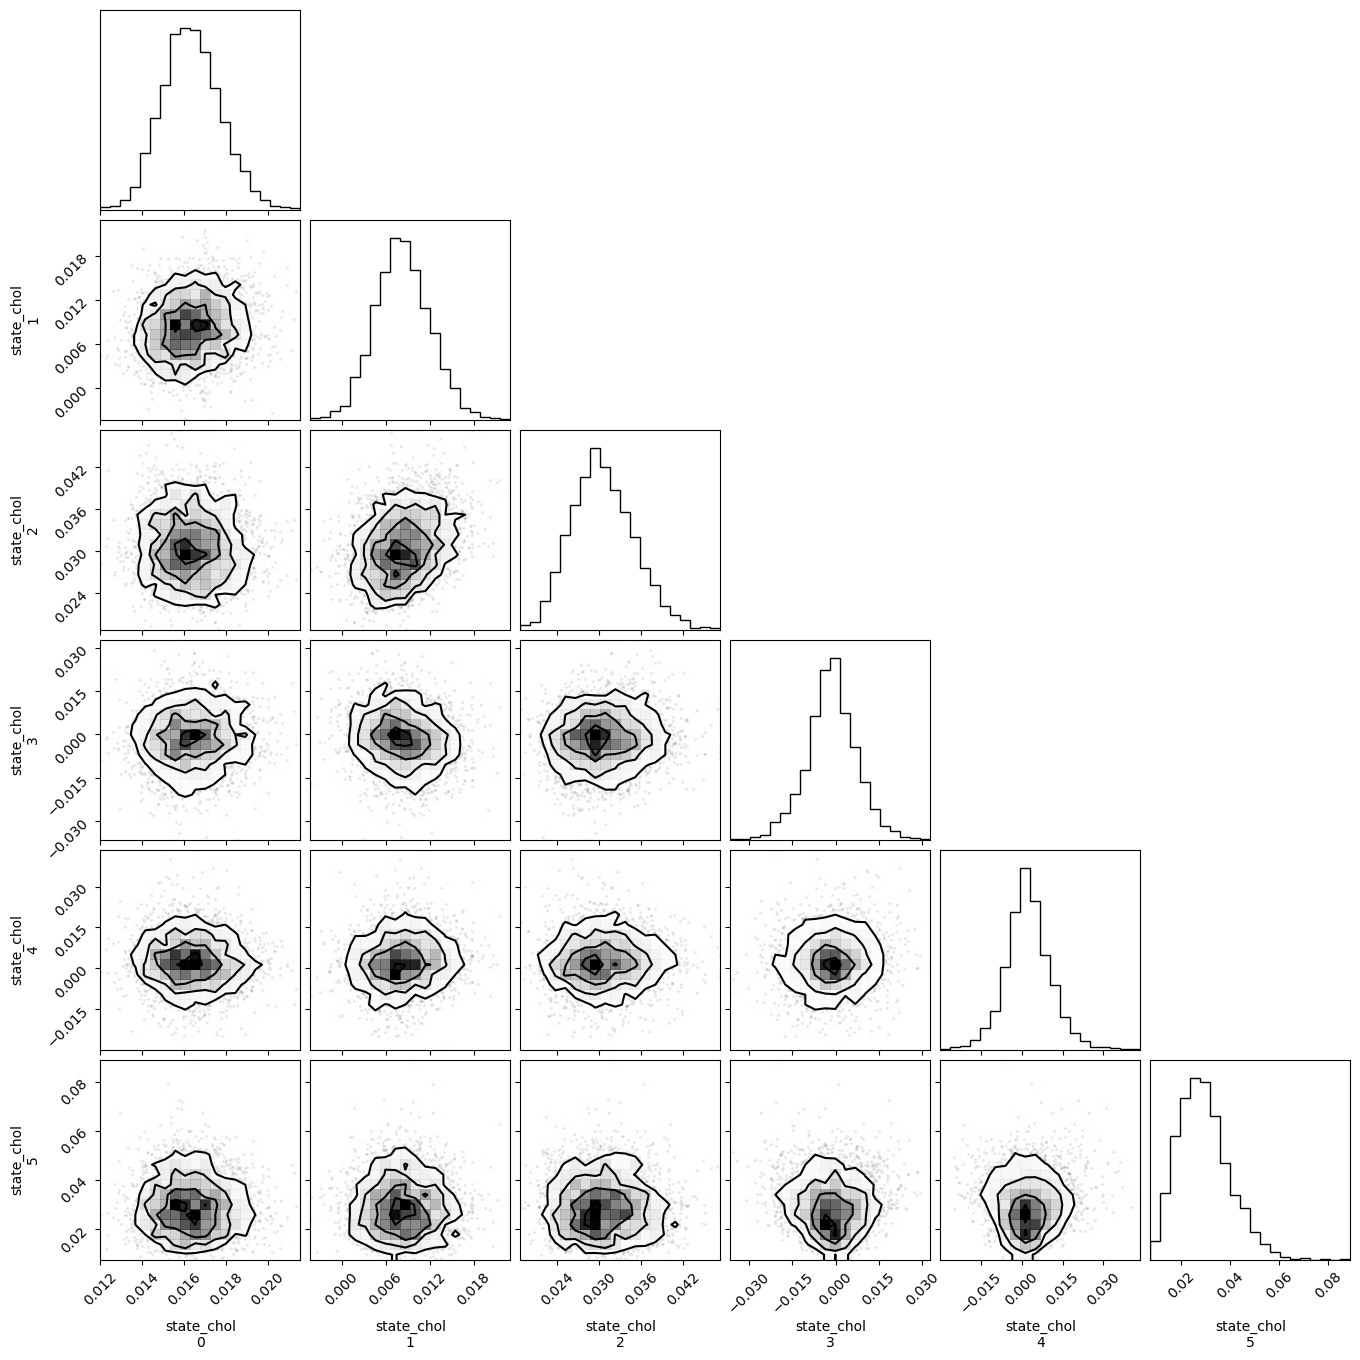

In [53]:
corner(idata, var_names=["state_chol"], marginals=True);

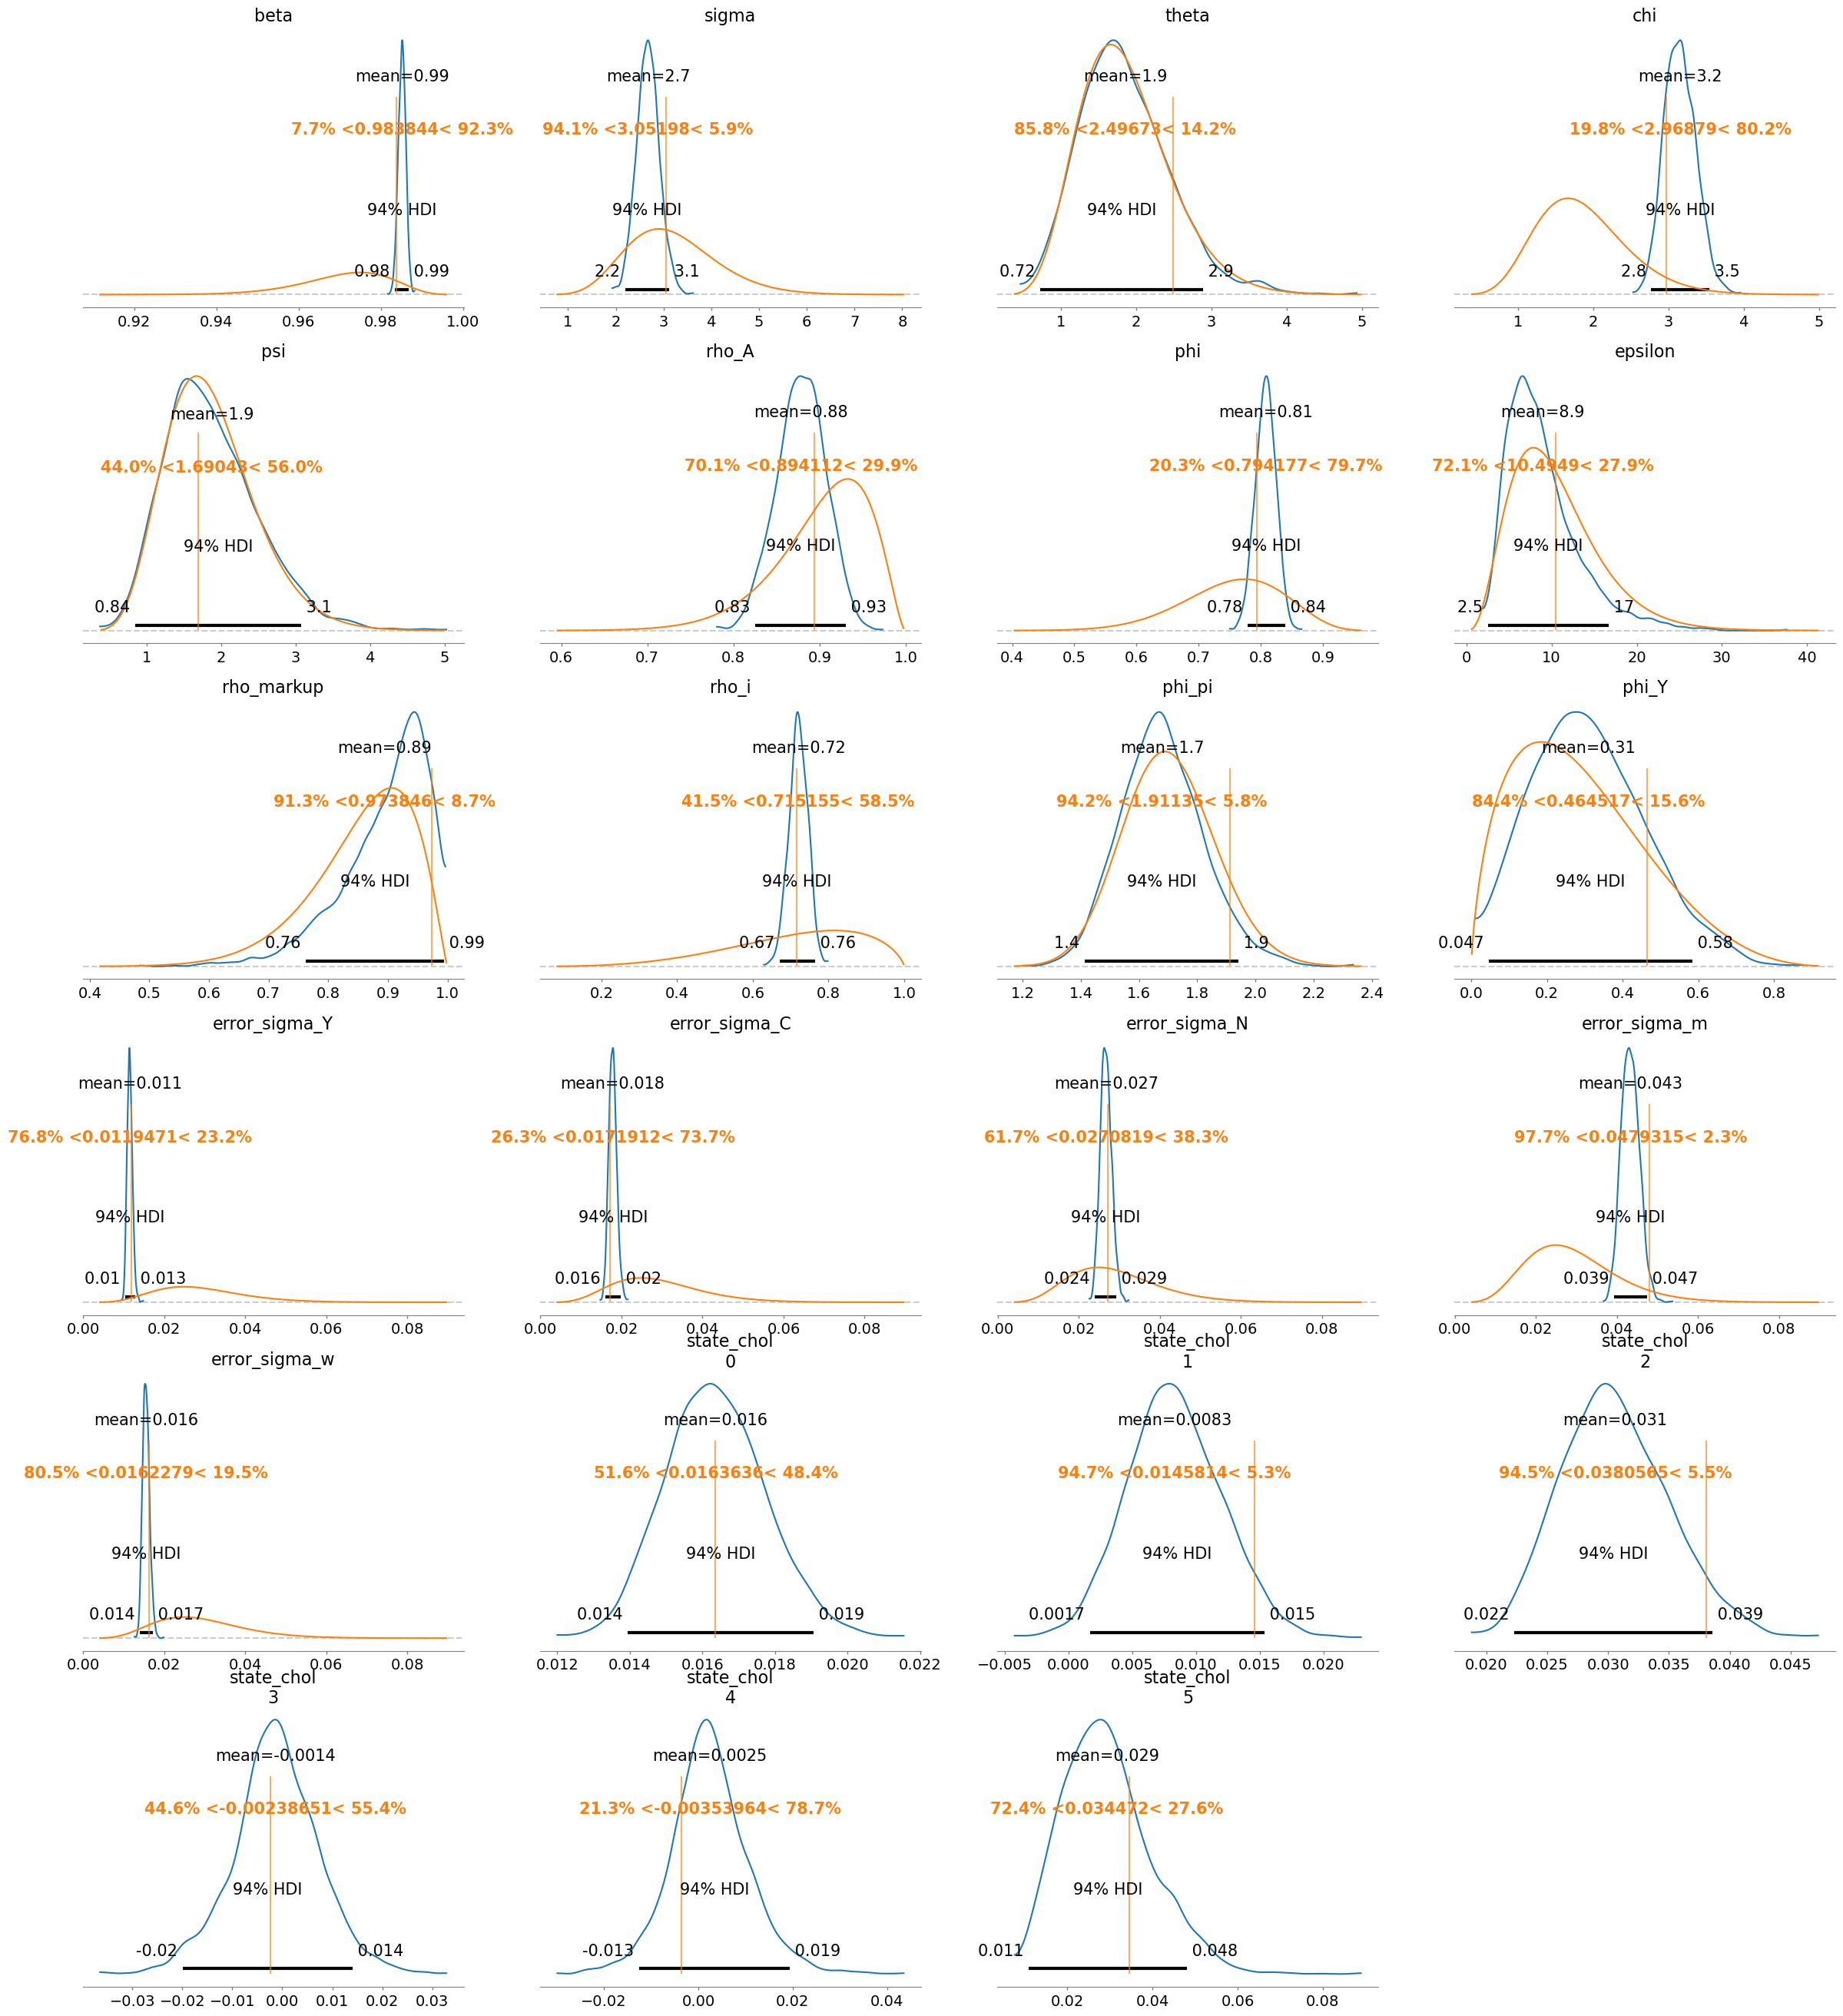

In [46]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")